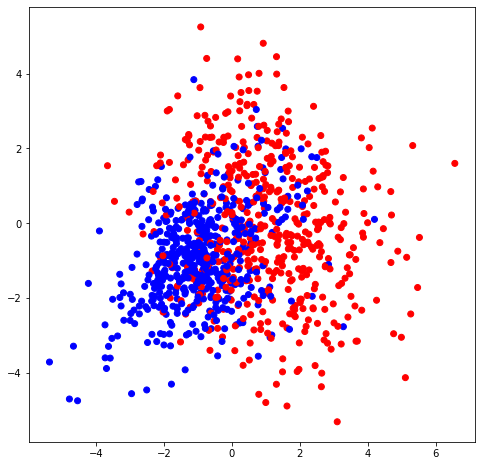

[1, 1, 1] [1, 0, 0] [1, 0, 1] [0, 0, 1]
[(1, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 1)]
Точность случайного леса из 1 деревьев на обучающей выборке: 93.429
Точность случайного леса из 1 деревьев на тестовой выборке: 81.000
Точность случайного леса из 3 деревьев на обучающей выборке: 97.857
Точность случайного леса из 3 деревьев на тестовой выборке: 84.667
Точность случайного леса из 10 деревьев на обучающей выборке: 98.857
Точность случайного леса из 10 деревьев на тестовой выборке: 86.333
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 88.000


In [1]:
# импортировать всё из урока 5 (вместо того чтобы копировать по частям)
# и заменить отдельные функции на свои согласно заданию
%run ./Lesson_5_210622.ipynb

1. Задание:  
    - Сформировать с помощью `sklearn.make_classification` датасет из 1000 объектов с **двумя** признаками.  
    - Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).  
    - Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`).   
    - Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=2, flip_y=0.1, random_state=1)

In [3]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X, 
                                                                    y, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [4]:
number_of_trees = (1, 3, 10, 50, 100, 200)
my_forest = {}
train_accuracy = {}
test_accuracy = {}
for n_trees in number_of_trees:
    my_forest[n_trees] = random_forest(train_data, train_labels, n_trees)
    train_answers = tree_vote(my_forest[n_trees], train_data)
    test_answers = tree_vote(my_forest[n_trees], test_data)
    train_accuracy[n_trees] = accuracy_metric(train_labels, train_answers)
    test_accuracy[n_trees] = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса\tиз {n_trees} деревьев\tна обучающей выборке: {train_accuracy[n_trees]:.3f}'
          f'\tна тестовой выборке: {test_accuracy[n_trees]:.3f}')

Точность случайного леса	из 1 деревьев	на обучающей выборке: 92.143	на тестовой выборке: 74.667
Точность случайного леса	из 3 деревьев	на обучающей выборке: 95.714	на тестовой выборке: 75.667
Точность случайного леса	из 10 деревьев	на обучающей выборке: 97.857	на тестовой выборке: 77.333
Точность случайного леса	из 50 деревьев	на обучающей выборке: 100.000	на тестовой выборке: 79.000
Точность случайного леса	из 100 деревьев	на обучающей выборке: 100.000	на тестовой выборке: 79.333
Точность случайного леса	из 200 деревьев	на обучающей выборке: 100.000	на тестовой выборке: 78.333


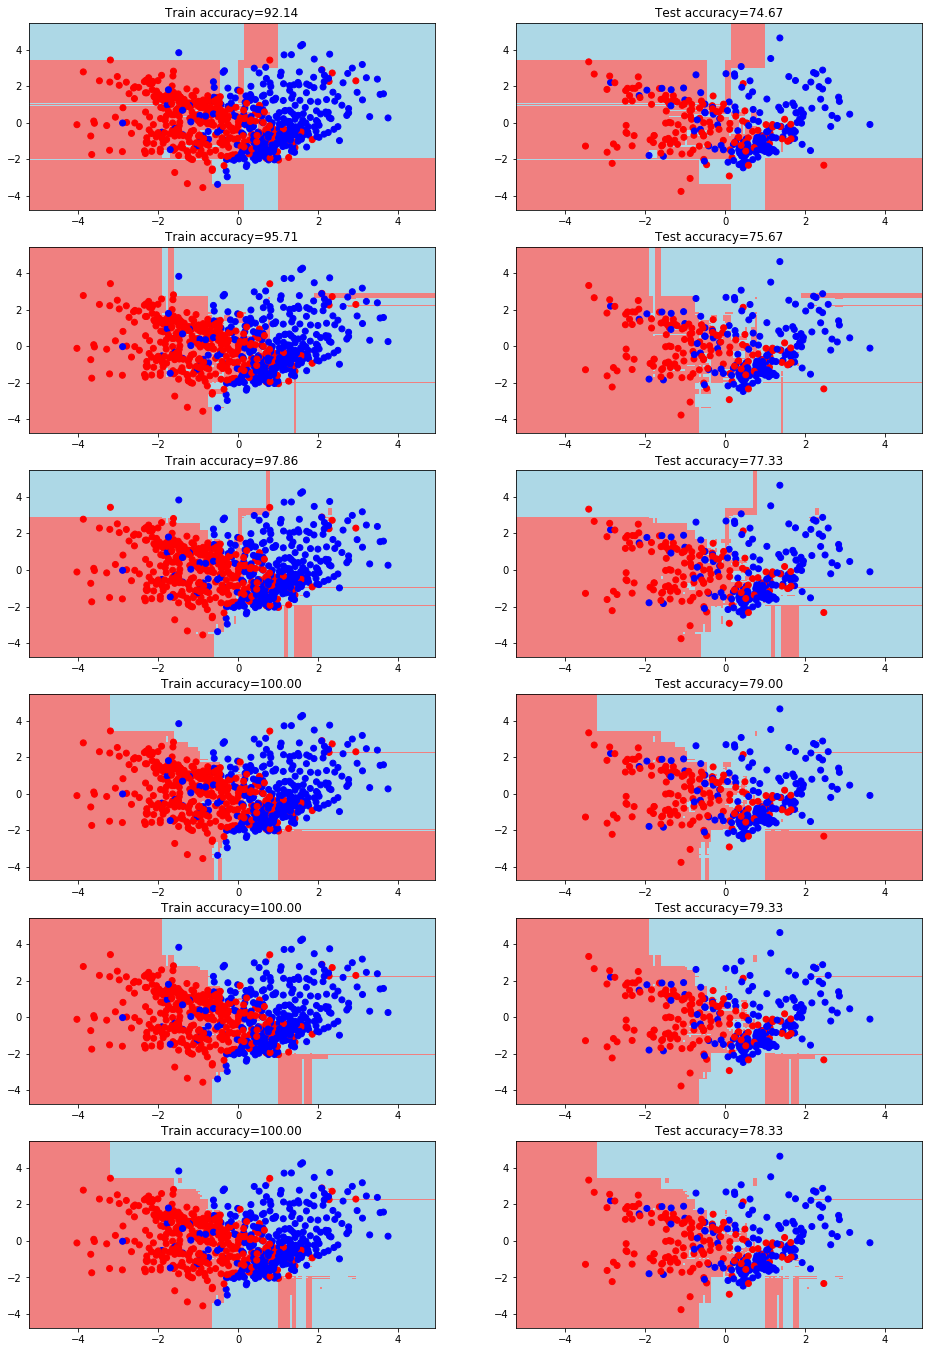

In [5]:
def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

xx, yy = get_meshgrid(train_data)
plt.figure(figsize=(16,24))
k = 1
for n_trees in number_of_trees:
    mesh_predictions = np.array(tree_vote(my_forest[n_trees], np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    
    plt.subplot(len(number_of_trees),2,k)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy[n_trees]:.2f}')
    k += 1

    plt.subplot(len(number_of_trees),2,k)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy[n_trees]:.2f}')
    k += 1

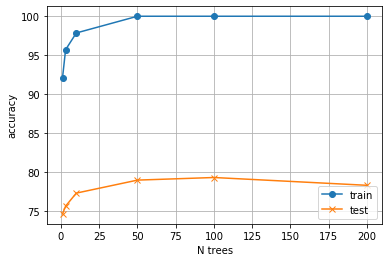

In [6]:
plt.plot(list(train_accuracy.keys()), list(train_accuracy.values()), marker='o', label='train')
plt.plot(list(test_accuracy.keys()), list(test_accuracy.values()), marker='x', label='test')

plt.xlabel("N trees")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

2. (\*) Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [50]:
def get_bootstrap_oob(data, labels, N):
    """генерация N бутстрап-выборок"""
    random.seed(42)
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_indexes = set()
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            b_indexes.add(sample_index)
        bootstrap.append((b_data, b_labels, b_indexes))
        
    return bootstrap

In [57]:
def random_forest_oob(data, labels, n_trees):
    """формирование случайного леса"""
    forest = []
    bootstrap = get_bootstrap_oob(data, labels, n_trees)
    
    tree_indexes = []
    
    for b_data, b_labels, b_indexes in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        tree_indexes.append(b_indexes)
        
    oob = []
    full_set =  set(range(data.shape[0]))
    for i, bootstrap_set in enumerate(tree_indexes):
        correct = 0
        out_of_bag_set = full_set.difference(bootstrap_set)
        if len(out_of_bag_set):
            for k in out_of_bag_set:
                pred = classify_object(data[k], forest[i])
                if labels[k] == pred:
                    correct += 1
            oob.append(correct / float(len(out_of_bag_set)) * 100.0)
            print(f"{i}: {oob[-1]:.2f}")
        
    return forest, np.mean(oob)

In [58]:
n_trees = 10
oob_forest, oob = random_forest_oob(X, y, n_trees)

0: 69.42
1: 74.07
2: 77.72
3: 76.52
4: 75.68
5: 78.02
6: 72.85
7: 77.68
8: 75.67
9: 75.83


In [59]:
print("OOB: {:.2f}".format(oob))

OOB: 75.35


In [60]:
train_answers = tree_vote(oob_forest, train_data)
test_answers = tree_vote(oob_forest, test_data)
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}\n')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.571
Точность случайного леса из 10 деревьев на тестовой выборке: 98.667

